# Variable Orientation

### This notebook use random_nfw_ellipsoid to create clouds of halo particles based on properties of halos in the halocat

Essentially identical to sample_orientations.ipyn

Using the halocat, instantiate a mock catalog. Then go through the halos chosen in that mock, create a random nfw halo using those a, b, and c values with z as the major axis, then rotate the z axis to the major axis of the halo it was built after. This process lets us see how close the axis calculated by the inertia tensor is to the true orientation as we adjust the resolution (number of particles). This notebook varies the resolution between each halo based on mass.

In [1]:
from halotools.sim_manager import HaloTableCache
from halotools.sim_manager import CachedHaloCatalog
from halotools_ia.correlation_functions import ed_3d, ee_3d
from halotools.utils import rotate_vector_collection

from halotools.empirical_models import HodModelFactory
from halotools.empirical_models import TrivialPhaseSpace, Leauthaud11Cens, Leauthaud11Sats, SubhaloPhaseSpace
from halotools_ia.ia_models.ia_model_components import CentralAlignment, RadialSatelliteAlignment
from halotools_ia.ia_models.ia_strength_models import RadialSatelliteAlignmentStrength

from halotools.utils.vector_utilities import (elementwise_dot, elementwise_norm, normalized_vectors,
                                              angles_between_list_of_vectors, vectors_normal_to_planes)

from ellipsoidal_nfw import random_nfw_ellipsoid

from halotools.utils import crossmatch

import numpy as np
import matplotlib.pyplot as plt

# This is not installed!!! Right now, these files are just sitting in the same directory
import inertia_tensors as itens

from generated_halo_helpers import downsample_halo, calculate_axes, separate_axes, get_angles, theta_phi, \
                                    get_rotation_matrix, extract_halo_properties, rotate_halos, generate_matching_halos, \
                                    mask_bad_halocat, get_halo_center

import warnings
warnings.filterwarnings("ignore")

### Get the halocat and instantiate a mock

Just as if we were going to analyze a mock catalog, get the halocat, mask out halos with 0 for all three orientation values, and create a model_instance with some occupation, profile, and orientation models. After that, I have extracted the rows from the halocat for the halos populated in the model. Because of how long this can take, I have further limited that table to a smaller subset of the halos chosen.

In [2]:
cache = HaloTableCache()
for entry in cache.log: print(entry)

#halocat = CachedHaloCatalog(simname='multidark', redshift=0)
halocat = CachedHaloCatalog(simname='bolshoi', halo_finder='rockstar', redshift=0, version_name='halotools_v0p4')
mask_bad_halocat(halocat)

('bolplanck', 'rockstar', 'halotools_v0p4', '-0.0023', 'C:\Users\nvana\.astropy\cache\halotools\halo_catalogs\bolplanck\rockstar\hlist_1.00231.list.halotools_v0p4.hdf5')
('bolshoi', 'rockstar', 'halotools_v0p4', '-0.0003', 'C:\Users\nvana\.astropy\cache\halotools\halo_catalogs\bolshoi\rockstar\hlist_1.00035.list.halotools_v0p4.hdf5')


In [3]:
# Create model to generate subsample of halos

cens_occ_model = Leauthaud11Cens
cens_prof_model = TrivialPhaseSpace
cens_orientation = CentralAlignment
sats_occ_model = Leauthaud11Sats
sats_prof_model1 = SubhaloPhaseSpace
prof_args1 = ("satellites", np.logspace(10.5, 15.2, 15))
sats_orientation = RadialSatelliteAlignment
sats_strength = RadialSatelliteAlignmentStrength()
Lbox = halocat.Lbox
sats_strength.inherit_halocat_properties(Lbox=Lbox)

model_instance = HodModelFactory(centrals_occupation = cens_occ_model(),
                                 centrals_profile = cens_prof_model(),
                                 satellites_occupation = sats_occ_model(),
                                 satellites_profile = SubhaloPhaseSpace(*prof_args1),
                                 satellites_radial_alignment_strength = sats_strength,
                                 centrals_orientation = cens_orientation(alignment_strength=1),
                                 satellites_orientation = sats_orientation(satellite_alignment_strength=1),
                                 model_feature_calling_sequence = (
                                 'centrals_occupation',
                                 'centrals_profile',
                                 'satellites_occupation',
                                 'satellites_profile',
                                 'satellites_radial_alignment_strength',
                                 'centrals_orientation',
                                 'satellites_orientation')
                                )
model_instance.populate_mock(halocat)

# Get the subsample of the halocat of the halos included in the model
hids = model_instance.mock.galaxy_table['halo_id']
inds1, inds2 = crossmatch(hids, halocat.halo_table['halo_id'])
subset = halocat.halo_table[inds2]

inds = np.random.choice( np.arange(len(subset)), int(len(subset)/7) )
subset = subset[inds]

In [4]:
rbins = np.logspace(-1,1.4,20)
rbin_centers = (rbins[:-1]+rbins[1:])/2.0

### Generate NFW halos

Now we can generate nfw halos based on the actual properties in our table of halos used in our model. To get more data, perform some number of runs (variable called runs below). Each of these runs, generate nfw halos for every halo in the subset table formed above with the resolution specified. To determine the resolution, each particle is given a mass. Specify the minimum number of particles to use, and the lowest mass divided by that number is the particle mass. After that, the resolution of a given halo is simply the rounded integer of the mass divided by the particle mass. You can also specify the max_particle number and specify the highest resolution to go. This can help speed up computation when there is a wide spread of masses. To avoid memory errors when trying to run the inertia tensor on large lists of halos, batch_size limits the number of nfw halos passed into the inertia tensor at a time. Lower this number if you get memory errors from the calculate_axes call.

Once the nfw halos have been generated, this calculates the angles between the axes of our nfw halos, and the true axes of the halos they were based on (ideally these thetas should be zero or small). It also calculates the shape-position (omega) and shape-shape (eta) correlation functions.

In [5]:
runs = 100
min_particle_num = 5      # Number of particles to assign to the lowest mass halo
max_particle_num = 1000  # Highest resolution to go

min_mass = min( subset["halo_mpeak"] )
particle_mass = min_mass/min_particle_num
resolutions = np.array( np.round( subset["halo_mpeak"]/particle_mass ) ).astype(int)
resolutions[ resolutions > max_particle_num ] = max_particle_num     # Limit high particle numbers to the max value

# Get the halo coords for ee and ed since they will never change
halo_coords = np.vstack((subset['halo_x'],
                            subset['halo_y'],
                            subset['halo_z'])).T

# Get the halo orientations to check the delta theta later
halo_orientations = np.vstack((subset['halo_axisA_x'],
                                subset['halo_axisA_y'],
                                subset['halo_axisA_z'])).T

thetas = []
omegas = []
etas = []

for i in range(runs):
    print(i)
    # Generate halos using the properties in the subset
    props = extract_halo_properties(subset)
    halos = generate_matching_halos(props, resolution=resolutions, rotate=True)
    
    axes = []
    # Since the halos are different resolutions, we now have a jagged array and can only do one halo at a time
    for halo in halos:
        lengths, evecs = separate_axes( calculate_axes( [halo] ) )
        axes.append( evecs[:,:,0] )
    
    # Stack the axes together into one array now and calculate the desired quantities
    axes = np.vstack( axes )
    thetas.append( angles_between_list_of_vectors( halo_orientations, axes ) )
    omegas.append( ed_3d(halo_coords, axes, halo_coords, rbins, period=halocat.Lbox) )
    etas.append( ee_3d(halo_coords, axes, halo_coords, axes, rbins, period=halocat.Lbox) )

# By the end of this loop, the folowing variables have the following shapes:
# angles - (runs, len(subsample) )
#    - Each list item is a list of all the angles between the generated axis and the halo axis they were modeled from
# omegas - (runs, rbins)
#    - Each list item is the result of ed_3d for that run, with a length equeal to rbins
# etas - (runs, rbins)
#    - same as omega

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### Results

Now we can view the histogram of the angles (in radians) between the true axes, and the axes of the nfw halos. Note that we have made the angle the minimum of the value calculated, and pi minus the value. This is because an angle of 0, and pi radians is the same for us since we don't care about antiparallel configurations. So we can only be up to pi/2 radians off.

In [6]:
flat_angles = np.hstack(thetas)
flat_angles = np.minimum(flat_angles, np.pi-flat_angles)

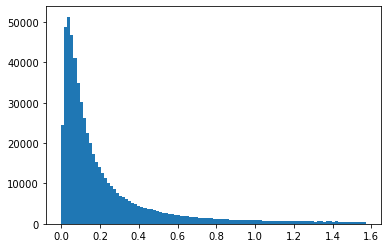

In [7]:
plt.hist(flat_angles,bins=100);

## Save Results

Since this notebook takes so long to run, these lines save the angles and correlation functions, as well as calculating and saving the correlation functions of the halos themselves for comparison.

In [8]:
np.save("../Results/flat_angles_variable_res_conc.npy",flat_angles)
np.save("../Results/omegas_variable_res_conc.npy",omegas)
np.save("../Results/etas_variable_res_conc.npy",etas)

In [9]:
halo_omega = ed_3d(halo_coords, halo_orientations, halo_coords, rbins, period=halocat.Lbox)
halo_eta = ee_3d(halo_coords, halo_orientations, halo_coords, halo_orientations, rbins, period=halocat.Lbox)

In [10]:
np.save("../Results/halo_omega_variable_res_conc.npy", halo_omega)
np.save("../Results/halo_eta_variable_res_conc.npy", halo_eta)

## Load Earlier Results

The next two cells are unnecessary if the whole notebook has just been run, but if you have previously saved values from an earlier run, you can jump straight here to load and view them

In [11]:
halo_omega = np.load("..\Results\halo_omega_variable_res_conc.npy")
halo_eta = np.load("..\Results\halo_eta_variable_res_conc.npy")
generated_omegas = np.load("..\Results\omegas_variable_res_conc.npy")
generated_etas = np.load("..\Results\etas_variable_res_conc.npy")

In [12]:
omega_means = np.mean(np.array(omegas), axis=0)
omega_std = np.std(np.array(omegas), axis=0)
eta_means = np.mean(np.array(etas), axis=0)
eta_std = np.std(np.array(etas), axis=0)

## View Results

Now we can look at the true correlation function aside that of the generated halos and their uncertainties

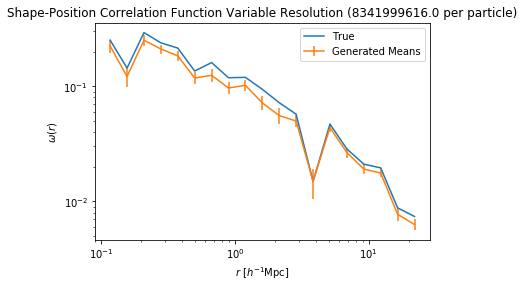

In [13]:
plt.plot(rbin_centers, halo_omega, label="True")
plt.errorbar(rbin_centers, omega_means, yerr=omega_std, label="Generated Means")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title("Shape-Position Correlation Function Variable Resolution ("+str(particle_mass)+" per particle)")
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\omega(r)$');

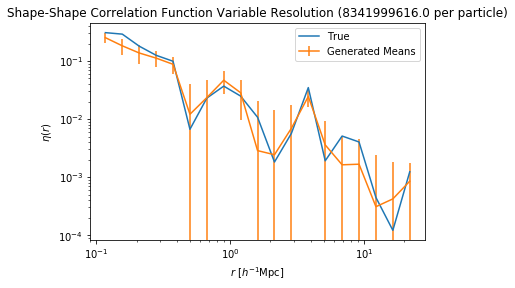

In [14]:
plt.plot(rbin_centers, abs(halo_eta), label="True")
plt.errorbar(rbin_centers, abs(eta_means), yerr=eta_std, label="Generated Means")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.title("Shape-Shape Correlation Function Variable Resolution ("+str(particle_mass)+" per particle)")
plt.xlabel(r'$r~[h^{-1}\rm Mpc]$')
plt.ylabel(r'$\eta(r)$');